## 題目
### Collect at least two customized rule-based patterns with indices.


# 概述

### 一、程式碼

* 所有檔案: util_pattern.py、 Process.py、Detect.py、Main.py

#### 1. util_pattern.py

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import mpl_finance as mpf


def pattern(df, signal, timeScale, path):         
    # 設定xy軸座標值、圖片標題大小       
    fontsize = 15
    plt.rcParams['xtick.labelsize'] = fontsize  
    plt.rcParams['ytick.labelsize'] = fontsize 
    plt.rcParams['axes.titlesize'] = fontsize           

    # 設定圖片的大小
    fig = plt.figure(figsize=(18, 12))
    ax = plt.subplot2grid((1, 1), (0, 0))          

    # 設定圖片背景為網格
    plt.grid()

    # 將x座標軸數值設為日期
    ax.set_xticks(range(10))
    ax.set_xticklabels(df['date'])      

    # 將x坐標軸數值旋轉45度
    locs, labels = plt.xticks() 
    plt.setp(labels , rotation = 45)

    # 繪出前幾根K棒的趨勢線
    global end_idx
    if signal == ('EveningStar' or 'MorningStar'):
        end_idx = 7
    elif signal == ('ShootingStar' or 'InvertHammer'):
        end_idx = 9
    elif signal == ('BearishHarami' or 'BearishEngulfing' or 'BullishHarami' or 'BullishEngulfing'):
        end_idx = 8 
    y = df['close'].iloc[0:end_idx].values.reshape(-1, 1)
    x = np.array(range(1, end_idx + 1)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)        
    ax.plot(y_pred, label='Trend')          

    # 繪出k棒 
    arr = np.c_[range(df.shape[0]), df[['open', 'high', 'low', 'close']].values]
    mpf.candlestick_ohlc(ax, arr, width=0.4, alpha=1, colordown='#53c156', colorup='#ff1717')    

    # 設定圖例位置與大小
    ax.legend(loc = 'best', prop = {'size': fontsize})

    # 設定圖片標題名字
    title_name = signal + '_' + timeScale
    ax.set_title(title_name)

    # 上調整個圖片的位置
    fig.subplots_adjust(bottom = 0.35)
   
    # 印出圖片
    plt.show()


G:\anad\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


#### Process.py

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression


class Process(object):
    def __init__(self, filename, timeScale):
        self.data = pd.read_csv(filename)
        self.timeScale = timeScale

    #預處理
    def preprocessing(self):
        # 將欄位名稱全部轉成小寫
        for i in self.data.columns.values:
            self.data.rename(columns={i : i.lower()}, inplace=True)       
        # 將日期從名目轉成時間尺度，並將其設為索引
        self.data['timestamp'] = pd.to_datetime(self.data['date'], format="%d.%m.%Y %H:%M:%S.%f")
        self.data.set_index('timestamp', inplace=True)
 

    #1.1:
    # 將資料的時間尺度轉成分鐘資料
    def timeConvert(self):
        df = pd.DataFrame(self.data['date'])
        df['low'] = self.data['low'].resample(self.timeScale, label='right', closed='right').min()
        df['high'] = self.data['high'].resample(self.timeScale, label='right', closed='right').max()
        df['close'] = self.data['close'].resample(self.timeScale, label='right', closed='right').last()
        df['open'] = self.data['open'].resample(self.timeScale, label='right', closed='right').first()
        self.data = df[1:-1]
        self.data.dropna(inplace=True)
    

    def percentile(self, series):
        t = series.iloc[-1]
        p = stats.percentileofscore(series, t, kind='strict')    
        return p

    #1.2 :
    #加新欄位
    def addFeature(self):
        # realbody: k棒長度，close - open
        # direction: k棒漲跌，realbody 的正負號
        # ushadow_width: 上引線長度，恆為正。如果k棒下跌，為high - open；如果k棒上跌，為high - close
        # lshadow_width: 下引線長度，恆為正。如果k棒下跌，為close - low；如果k棒上跌，為open - low
        # ushadow_per: 上引線長度在前50根k棒中的PR值
        # lshadow_per: 下引線長度在前50根k棒中的PR值
        # realbody_per: K棒長度在前50根k棒中的PR值
        self.data['realbody'] = self.data['close'] - self.data['open']
        self.data['direction'] = np.sign(self.data['realbody'])
        self.data['ushadow_width'], self.data['lshadow_width'] = 0, 0
        self.data.loc[self.data['realbody'] <= 0, 'ushadow_width'] = self.data.loc[self.data['realbody'] <= 0, 'high'] - self.data.loc[self.data['realbody'] <= 0, 'open']
        self.data.loc[self.data['realbody'] > 0, 'ushadow_width'] = self.data.loc[self.data['realbody'] > 0, 'high'] - self.data.loc[self.data['realbody'] > 0, 'close']
        self.data.loc[self.data['realbody'] <= 0, 'lshadow_width'] = self.data.loc[self.data['realbody'] <= 0, 'close'] - self.data.loc[self.data['realbody'] <= 0, 'low']
        self.data.loc[self.data['realbody'] > 0, 'lshadow_width'] = self.data.loc[self.data['realbody'] > 0, 'open'] - self.data.loc[self.data['realbody'] > 0, 'low']
        self.data['ushadow_per'] = self.data['ushadow_width'].rolling(50).apply(self.percentile, raw=False)
        self.data['lshadow_per'] = self.data['lshadow_width'].rolling(50).apply(self.percentile, raw=False)
        self.data['realbody_per'] = abs(self.data['realbody']).rolling(50).apply(self.percentile, raw=False)        
        self.data.dropna(inplace = True)
        return self.data

#### 3. Detect.py

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


class Detect(object):
    def __init__(self, filename):
        self.data = pd.read_csv(filename)
        self.timeScale = None
    

    def trending(self, series):
        # 以線性回歸的斜率決定趨勢，斜率為正，趨勢為正向，輸出1；反之為趨勢為負向，輸出-1。
        # 斜率為0，輸出0
        y = series.values.reshape(-1,1)
        x = np.array(range(1, series.shape[0] + 1)).reshape(-1,1)
        model = LinearRegression()
        model.fit(x, y)
        slope = model.coef_
        if slope > 0:
            return 1
        elif slope == 0:
            return 0
        else:
            return -1
    

    def eveningStar(self, df):

        cond1 = (df['trend7'].iloc[-4] > 0)
        cond2 = (df['direction'].iloc[-3] > 0)
        cond3 = (df['direction'].iloc[-1] < 0)
        cond4 = (df['realbody_per'].iloc[-3] >= 65)
        cond5 = (df['realbody_per'].iloc[-2] <= 35)
        cond6 = (df['close'].iloc[-1] <= (df['open'].iloc[-3] + df['realbody'].iloc[-3] * (1/2)))
        cond7 = (df['close'].iloc[-3] <= (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        cond8 = (df['open'].iloc[-1] <= (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 and cond7 and cond8:
            return True
        else:
            return False
    
    def bearishHarami(self, df):
        cond1 = (df['trend8'].iloc[-3] > 0)
        cond2 = (df['direction'].iloc[-2] > 0)
        cond3 = (df['direction'].iloc[-1] < 0)
        cond4 = (df['realbody_per'].iloc[-2] >= 65)
        cond5 = (df['open'].iloc[-1] < df['close'].iloc[-2])
        cond6 = (df['close'].iloc[-1] > df['open'].iloc[-2])
        cond7 = (df['realbody_per'].iloc[-1] >= 65)
        cond8 = (df['close'].iloc[-1] <= (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 and cond7 and cond8:
            return True
        else:
            return False

    def shootingStar(self, df):
        cond1 = (df['trend9'].iloc[-2] > 0)
        cond2 = (df['direction'].iloc[-2] > 0)
        cond3 = (df['realbody_per'].iloc[-2] >= 65)
        cond4 = (df['ushadow_width'].iloc[-1] >= 2 * abs(df['realbody'].iloc[-1]))
        cond5 = (min(df['open'].iloc[-1], df['close'].iloc[-1]) >= (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        cond6 = (df['lshadow_per'].iloc[-1] <= 25)
        cond7 = (df['ushadow_per'].iloc[-1] >= 65)
        if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 and cond7:
            return True
        else:
            return False
    

    def process(self):
        # 將日期從名目轉成時間尺度
        self.data['date'] = pd.to_datetime(self.data['date'], format="%d.%m.%Y %H:%M:%S.%f")
        # 檢查時間尺度為何
        if 60 <= (self.data['date'].iloc[1] - self.data['date'].iloc[0]).seconds < 1800 :
            self.timeScale = '1m'
        elif 1800 <= (self.data['date'].iloc[1] - self.data['date'].iloc[0]).seconds < 3600:
            self.timeScale = '30m'
        elif 3600 <= (self.data['date'].iloc[1] - self.data['date'].iloc[0]).seconds < 86400:
            self.timeScale = '1H'
        elif 1 <= (self.data['date'].iloc[1] - self.data['date'].iloc[0]).days < 7:
            self.timeScale = '1D'
        elif (self.data['date'].iloc[1] - self.data['date'].iloc[0]).days >= 7:
            self.timeScale = '1W'
        # 新增欲偵測的交易訊號
        self.data['EveningStar'] = 0 
        self.data['ShootingStar'] = 0
        self.data['BearishHarami'] = 0
        self.data['None'] = 0
    
    #2：
    def trend(self):
        # 以線性回歸的斜率分別計算前7, 8, 9根k棒的趨勢，斜率大於0則趨勢為正，位於趨勢線最尾端的資料的欄位值為1；反之則為-1
        self.data['trend7'] = self.data['close'].rolling(7).apply(self.trending, raw=False)
        self.data['trend8'] = self.data['close'].rolling(8).apply(self.trending, raw=False)
        self.data['trend9'] = self.data['close'].rolling(9).apply(self.trending, raw=False)
    
    
    #3：
    def signal(self):
        # 以10根k棒為單位進行偵測，如符合特定交易訊號，則第10根k棒在該交易訊號的欄位的值為1，反之為0
        # 如均不符合任何交易訊號，則第10根k棒在None的欄位值為1
        for idx in tqdm(self.data.index):
            start_idx, end_idx = (idx - 9), idx
            if start_idx >= 0:
                df = self.data.loc[start_idx:end_idx]
                if self.eveningStar(df):
                    self.data.loc[end_idx, 'EveningStar'] = 1                
                elif self.shootingStar(df):
                    self.data.loc[end_idx, 'ShootingStar'] = 1   
                elif self.bearishHarami(df):
                    self.data.loc[end_idx, 'BearishHarami'] = 1                
                else:
                    self.data.loc[end_idx, 'None'] = 1
        return self.data
    
  
   
    # 印出每個交易訊號下偵測到幾個pattern
    def result(self):
        print('Time Scale: %s' % (self.timeScale))
        print('Period: %s - %s' % (self.data['date'].iloc[9], self.data['date'].iloc[-1]))
        print('The Number of Patterns in Each Signal:')
        print('None: {}'.format(self.data.loc[self.data['None'] == 1, 'None'].shape[0]))
        print('EveningStar: {}'.format(self.data.loc[self.data['EveningStar'] == 1, 'EveningStar'].shape[0]))                   
        print('ShootingStar: {}'.format(self.data.loc[self.data['ShootingStar'] == 1, 'ShootingStar'].shape[0]))
        print('BearishHarami: {}'.format(self.data.loc[self.data['BearishHarami'] == 1, 'BearishHarami'].shape[0]))


#### 4. Main.py

In [4]:
import os
import pandas as pd
from tqdm import tqdm
from random import sample 

from Process import Process
from Detect import Detect
from util_pattern import pattern

pd.set_option('display.max_columns', 1000)

In [5]:
class Main(object):
    def __init__(self, filename_raw, filename_pro, filename_rule, pattern_path, timeScale):
        self.data_pro_df = None
        self.data_rule_df = None
        self.filename_raw = filename_raw
        self.filename_pro = filename_pro
        self.filename_rule = filename_rule
        self.pattern_path = pattern_path
        self.timeScale = timeScale
    

    def save(self, data, filename, file_format):
        # 儲存csv和pickle檔
        if file_format == 'csv':
            data.to_csv(filename, index = False)
        elif file_format == 'pickle':
            with open(filename, 'wb+') as f:
                pickle.dump(data, f)


    def load(self, filename, file_format):
        # 載入csv和pickle檔
        if file_format == 'csv':
            data = pd.read_csv(filename)
            return data
        elif file_format == 'pickle':
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            return data


    def process(self):
        # 呼叫process.py檔，做資料前處理
        Pro = Process(self.filename_raw, self.timeScale)
        Pro.preprocessing()
        Pro.timeConvert()
        self.data_pro_df = Pro.addFeature()
        self.save(self.data_pro_df, self.filename_pro, 'csv')
    

    def detect(self):
        # 呼叫Detect.py檔，做rule-base偵測
        Det = Detect(self.filename_pro)
        Det.process()
        Det.trend()
        self.data_rule_df = Det.signal()
        Det.result()
        self.save(self.data_rule_df, self.filename_rule, 'csv')
    

    def graph(self, signal, num_pattern = 1):
        # 繪出符合交易訊號的pattern
        data_df = self.load(self.filename_rule, 'csv')
        idx_signal_ls = list(data_df.loc[data_df[signal] == 1].index)
        idx_signal_sample_ls = sample(idx_signal_ls, num_pattern)
        for idx in tqdm(idx_signal_sample_ls):
            idx_start, idx_end = (idx - 9), idx
            df = data_df.loc[idx_start:idx_end]
            path = self.pattern_path + '/' + str(signal)
            pattern(df, signal, self.timeScale, path)
    
# if __name__=='__main__':
#     filename_raw = './data/eurusd_2010_2017.csv'
#     filename_pro = './data/eurusd_2010_2017_1T.csv'
#     filename_rule = './data/eurusd_2010_2017_1T_rulebase.csv'
#     pattern_path = './data/lecture_ntu/pattern'
#     timeScale = '1min'
#     signal_ls = ['EveningStar', 'ShootingStar', 'BearishHarami']
    
#     M =  Main(filename_raw, filename_pro, filename_rule, pattern_path, timeScale)
#     M.process()
#     M.detect()
    
#     M.graph('EveningStar')
#     M.graph('ShootingStar')
#     M.graph('BearishHarami')
    
#     print("over")

### 二、執行

In [6]:
filename_raw = './data/eurusd_2010_2017.csv'
filename_pro = './data/eurusd_2010_2017_1T.csv'
filename_rule = './data/eurusd_2010_2017_1T_rulebase.csv'
pattern_path = './data/lecture_ntu/pattern'
timeScale = '1min'
signal_ls = ['EveningStar', 'ShootingStar', 'BearishHarami']

In [7]:
M =  Main(filename_raw, filename_pro, filename_rule, pattern_path, timeScale)

#### 1. Data Processing

In [8]:
M.process()

C:\python\temp\HW1_ID_姓名\Process.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.dropna(inplace=True)


In [9]:
M.data_pro_df.head(10)

,date,low,high,close,open,realbody,direction,ushadow_width,lshadow_width,ushadow_per,lshadow_per,realbody_per
timestamp,,,,,,,,,,,,
2010-01-01 00:52:00,01.01.2010 00:52:00.000,1.43266,1.43281,1.43275,1.43272,0.00003,1.0,0.00006,0.00006,78.0,70.0,16.0
2010-01-01 00:53:00,01.01.2010 00:53:00.000,1.43269,1.43285,1.43274,1.43272,0.00002,1.0,0.00011,0.00003,92.0,44.0,8.0
2010-01-01 00:54:00,01.01.2010 00:54:00.000,1.43278,1.43292,1.43278,1.43285,-0.00007,-1.0,0.00007,0.00000,84.0,0.0,46.0
2010-01-01 00:55:00,01.01.2010 00:55:00.000,1.43278,1.43291,1.43285,1.43278,0.00007,1.0,0.00006,0.00000,72.0,0.0,44.0
2010-01-01 00:56:00,01.01.2010 00:56:00.000,1.43277,1.43290,1.43282,1.43284,-0.00002,-1.0,0.00006,0.00005,70.0,58.0,8.0
2010-01-01 00:57:00,01.01.2010 00:57:00.000,1.43279,1.43289,1.43283,1.43289,-0.00006,-1.0,0.00000,0.00004,0.0,52.0,36.0
2010-01-01 00:58:00,01.01.2010 00:58:00.000,1.43278,1.43290,1.43290,1.43280,0.00010,1.0,0.00000,0.00002,0.0,46.0,66.0
2010-01-01 00:59:00,01.01.2010 00:59:00.000,1.43276,1.43291,1.43276,1.43286,-0.00010,-1.0,0.00005,0.00000,66.0,0.0,64.0
2010-01-01 01:00:00,01.01.2010 01:00:00.000,1.43254,1.43288,1.43256,1.43287,-0.00031,-1.0,0.00001,0.00002,42.0,48.0,88.0


#### 2. Data Labeling

In [10]:
M.detect()

100%|█████████████████████████████████████████████████████████████████████| 1048524/1048524 [2:38:27<00:00, 110.28it/s]


Time Scale: 1m
Period: 2010-01-01 01:01:00 - 2012-11-28 04:35:00
The Number of Patterns in Each Signal:
None: 1042576
EveningStar: 988
ShootingStar: 2863
BearishHarami: 2088


In [11]:
M.data_rule_df.head(10)

,date,low,high,close,open,realbody,direction,ushadow_width,lshadow_width,ushadow_per,lshadow_per,realbody_per,EveningStar,ShootingStar,BearishHarami,None,trend7,trend8,trend9
0,2010-01-01 00:52:00,1.43266,1.43281,1.43275,1.43272,0.00003,1.0,0.00006,0.00006,78.0,70.0,16.0,0,0,0,0,NaN,NaN,NaN
1,2010-01-01 00:53:00,1.43269,1.43285,1.43274,1.43272,0.00002,1.0,0.00011,0.00003,92.0,44.0,8.0,0,0,0,0,NaN,NaN,NaN
2,2010-01-01 00:54:00,1.43278,1.43292,1.43278,1.43285,-0.00007,-1.0,0.00007,0.00000,84.0,0.0,46.0,0,0,0,0,NaN,NaN,NaN
3,2010-01-01 00:55:00,1.43278,1.43291,1.43285,1.43278,0.00007,1.0,0.00006,0.00000,72.0,0.0,44.0,0,0,0,0,NaN,NaN,NaN
4,2010-01-01 00:56:00,1.43277,1.43290,1.43282,1.43284,-0.00002,-1.0,0.00006,0.00005,70.0,58.0,8.0,0,0,0,0,NaN,NaN,NaN
5,2010-01-01 00:57:00,1.43279,1.43289,1.43283,1.43289,-0.00006,-1.0,0.00000,0.00004,0.0,52.0,36.0,0,0,0,0,NaN,NaN,NaN
6,2010-01-01 00:58:00,1.43278,1.43290,1.43290,1.43280,0.00010,1.0,0.00000,0.00002,0.0,46.0,66.0,0,0,0,0,1.0,NaN,NaN
7,2010-01-01 00:59:00,1.43276,1.43291,1.43276,1.43286,-0.00010,-1.0,0.00005,0.00000,66.0,0.0,64.0,0,0,0,0,1.0,1.0,NaN
8,2010-01-01 01:00:00,1.43254,1.43288,1.43256,1.43287,-0.00031,-1.0,0.00001,0.00002,42.0,48.0,88.0,0,0,0,0,-1.0,-1.0,-1.0
9,2010-01-01 01:01:00,1.43246,1.43260,1.43260,1.43250,0.00010,1.0,0.00000,0.00004,0.0,62.0,62.0,0,0,0,1,-1.0,-1.0,-1.0


#### 3. Graphing

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

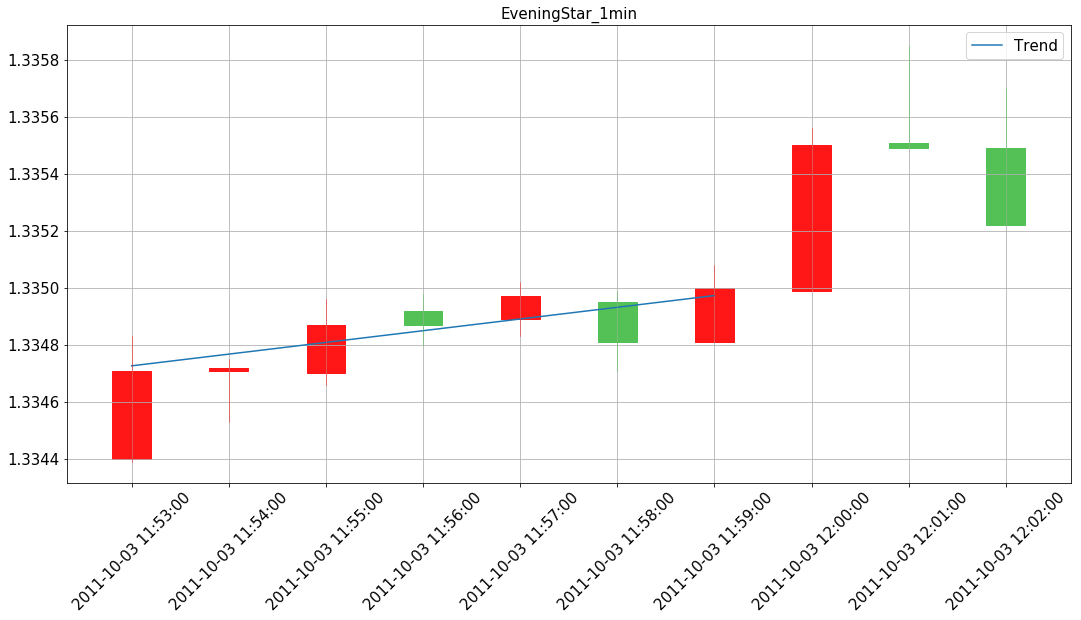

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


In [12]:
M.graph('EveningStar')

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

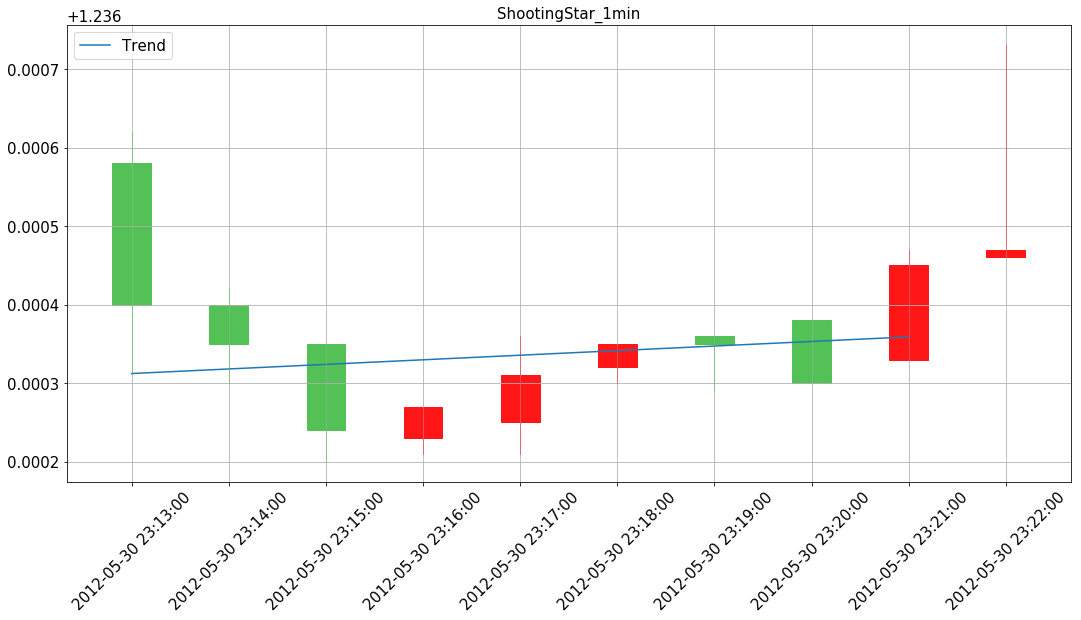

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


In [13]:
M.graph('ShootingStar')

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

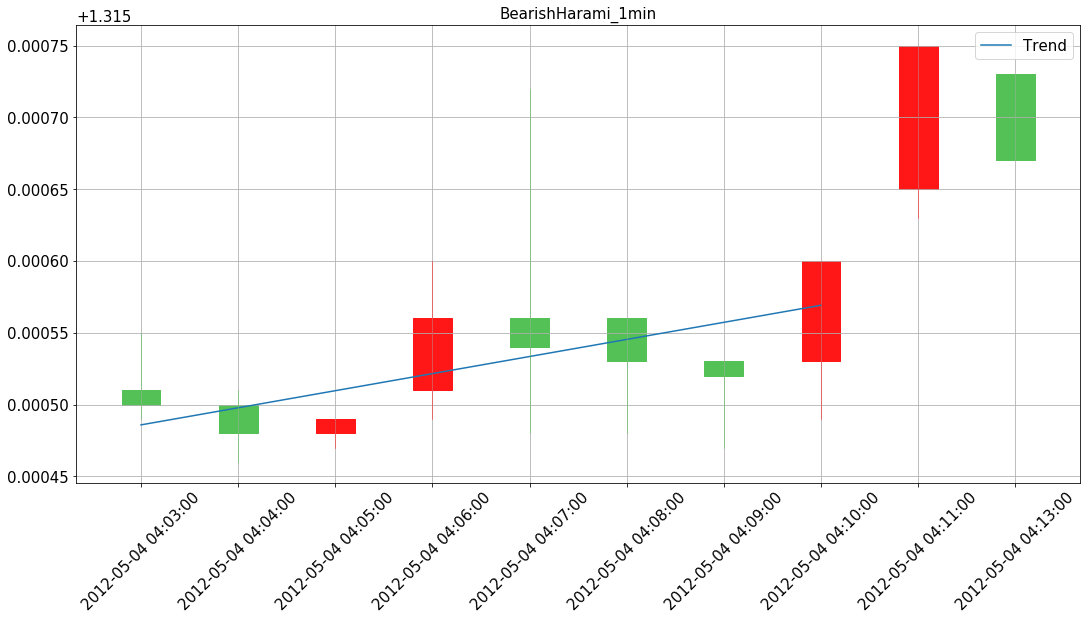

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


In [14]:
M.graph('BearishHarami')

## 三、參考資料

- Stephen W. Bigalow. THE MAJOR CANDLESTICKS SIGNALS “12 Signals to Master any Market”. The Candlestick Forum LLC.